In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Patch



In [ ]:
# load the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class VAE(nn.Module):
    def __init__(
          self,
          x_dim,
          hidden_dim,
          z_dim,
          cond_dim
        ):
        super(VAE, self).__init__()

        # Define autoencoding layers
        self.l_dim = z_dim
        self.enc_layer1 = nn.Linear(x_dim+cond_dim, hidden_dim)
        self.enc_layer2_mu = nn.Linear(hidden_dim, z_dim)
        self.enc_layer2_logvar = nn.Linear(hidden_dim, z_dim)
        self.rec_loss = []
        self.rec_loss = []
        self.kl_div = []
        self.mse = []
        self.latent = torch.empty((64, 9), dtype=torch.int64)


        # Define autoencoding layers
        self.dec_layer1 = nn.Linear(z_dim + cond_dim, hidden_dim)
        self.dec_layer2 = nn.Linear(hidden_dim, x_dim)

    def encoder(self, x):
        # Now, both x and y should have the same number of rows, enabling concatenation along dim=1
        x = F.relu(self.enc_layer1(x))
        mu = self.enc_layer2_mu(x)
        logvar = self.enc_layer2_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def decoder(self, z):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        #print(z.shape)
        self.latent = z
        z.to(device)
        # Define decoder network
        output = F.relu(self.dec_layer1(z))
        output = F.relu(self.dec_layer2(output))
        return output

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        #print(type(z))
        output = self.decoder(z)
        return output, z, mu, logvar

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random nois
            z = torch.randn(num_samples, self.l_dim).to(device)

            samples = self.decoder(z)
        # Return the generated samples
        return samples


In [ ]:


# Define the loss function
def loss_function(output, x, mu, logvar):
    recon_loss = F.mse_loss(output, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss +  kl_loss) / mu.shape[0] , kl_loss / mu.shape[0] , recon_loss / mu.shape[0]


In [ ]:
def train_model(
    X,
    latent_dim,
    learning_rate=1e-4,
    batch_size=64,
    num_epochs=400,
    hidden_dim=15,
  ):
    # Define the VAE model
  model = VAE(x_dim=X.shape[1], hidden_dim=hidden_dim, z_dim=latent_dim, cond_dim=0)

  # Define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
  # load the device
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  # Convert X & Y to a PyTorch tensor
  X = torch.tensor(X).float()
  X.to(device)


  # Create DataLoader object to generate minibatches
  dataset = TensorDataset(X)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  model.to(device)

  # Train the model
  for epoch in range(num_epochs):
      epoch_loss = 0
      kl_total = 0
      mse_total = 0
      for batch in dataloader:
          # Zero the gradients
          optimizer.zero_grad()

          # Get batch
          x = batch[0].to(device)

          # Forward pass
          output, z, mu, logvar = model(x)

          # Calculate loss
          loss, kl, mse = loss_function(output, x, mu, logvar)

          # Backward pass
          loss.backward()

          # Update parameters
          optimizer.step()

          # Add batch loss to epoch loss
          epoch_loss += loss.item()
          kl_total += kl.item()
          mse_total += mse.item()



      model.rec_loss.append(epoch_loss /len(X))
      model.kl_div.append(kl_total /len(X))
      model.mse.append(mse_total /len(X))



      # Print epoch loss
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(X)}, KL: {kl_total/len(X)}, MSE: {mse_total/len(X)}")


  return model

In [ ]:
data_complete =  pd.read_csv("/content/Continuous_Pathway_I_VAE_dataset1.csv").drop('Unnamed: 0', axis=1)
flux = data_complete['Product_I']
features = data_complete.drop('Product_I', axis=1)
feature_names = list(features.columns)
feat = features.values  # Convert data to numpy array

In [ ]:
latent = 11

In [ ]:
vae = train_model(feat, latent)
print(vae)

Epoch 1/400, Loss: 0.44725792388916014, KL: 0.010456691157817841, MSE: 0.4368012321472168
Epoch 2/400, Loss: 0.42167674674987793, KL: 0.010322633707523347, MSE: 0.4113541130065918
Epoch 3/400, Loss: 0.3887419128417969, KL: 0.014330933487415314, MSE: 0.3744109790802002
Epoch 4/400, Loss: 0.3439208385467529, KL: 0.02450523021221161, MSE: 0.31941560821533205
Epoch 5/400, Loss: 0.29517488861083985, KL: 0.040170143699646, MSE: 0.2550047456741333
Epoch 6/400, Loss: 0.2473834011077881, KL: 0.053287947130203246, MSE: 0.1940954538345337
Epoch 7/400, Loss: 0.21089539985656738, KL: 0.056389832639694215, MSE: 0.15450556697845458
Epoch 8/400, Loss: 0.1874815071105957, KL: 0.055461194086074826, MSE: 0.132020313167572
Epoch 9/400, Loss: 0.1737681707382202, KL: 0.05410063910484314, MSE: 0.11966753225326537
Epoch 10/400, Loss: 0.16338478965759276, KL: 0.052062227821350095, MSE: 0.11132256145477296
Epoch 11/400, Loss: 0.15526133346557616, KL: 0.04935986099243164, MSE: 0.10590147247314453
Epoch 12/400, L

In [ ]:
generated_samples = vae.sample(5000)
generated_samples = generated_samples.cpu()

pca_real = PCA(n_components=latent)
real_result = pca_real.fit_transform(feat)

pca_synthetic = PCA(n_components=latent)
synthetic_result = pca_synthetic.fit_transform(generated_samples.detach().numpy())

pca = PCA(n_components=latent, random_state=42)  # Choose the number of components for visualization
latent_2d = pca.fit_transform(vae.latent.cpu())

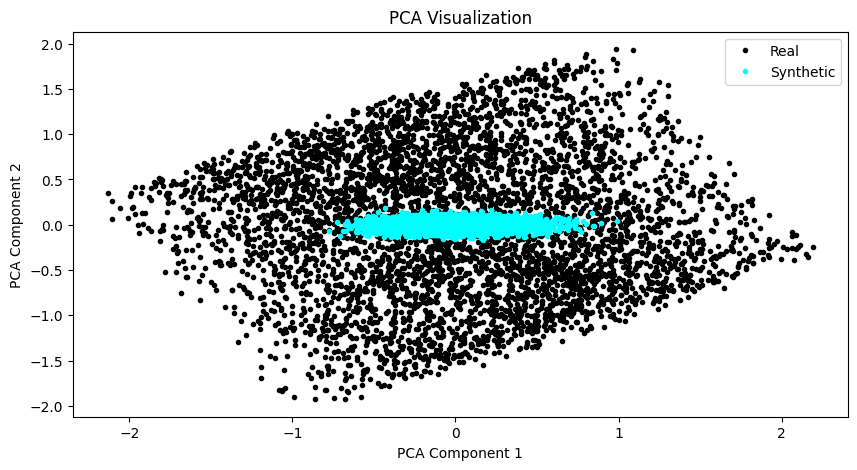

In [ ]:
feature_1 = 0
feature_2 = 1


plt.figure(figsize=(10, 5))
plt.plot(real_result[:,feature_1], real_result[:, feature_2],".", color='black')
plt.plot(synthetic_result[:5000,feature_1], synthetic_result[:5000, feature_2],".", color='cyan')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization')

plt.legend(['Real', 'Synthetic'])
plt.show()



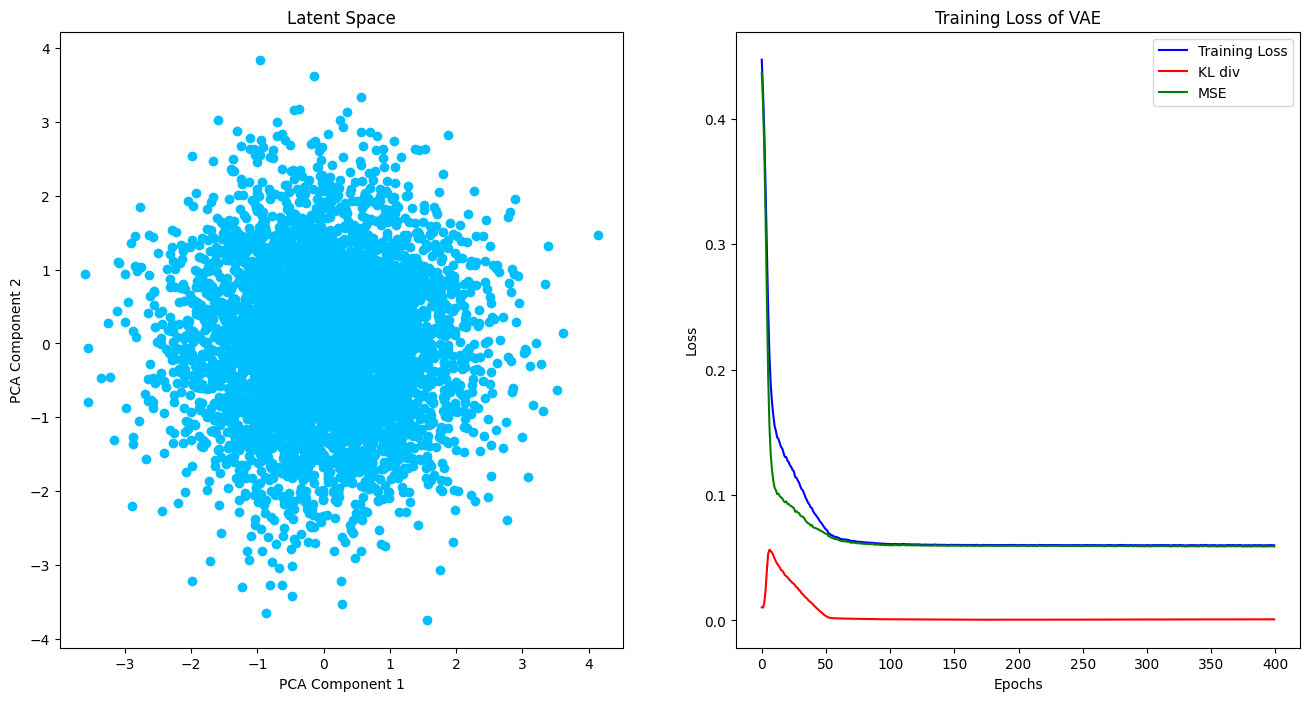

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(latent_2d[:, feature_1], latent_2d[:, feature_2],  c="deepskyblue")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title("Latent Space")

plt.subplot(1, 2, 2)

plt.plot(vae.rec_loss, label='Training Loss', c ="blue")
plt.plot(vae.kl_div, label='KL div', c="red")
plt.plot(vae.mse, label='MSE', c="green")

plt.title('Training Loss of VAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

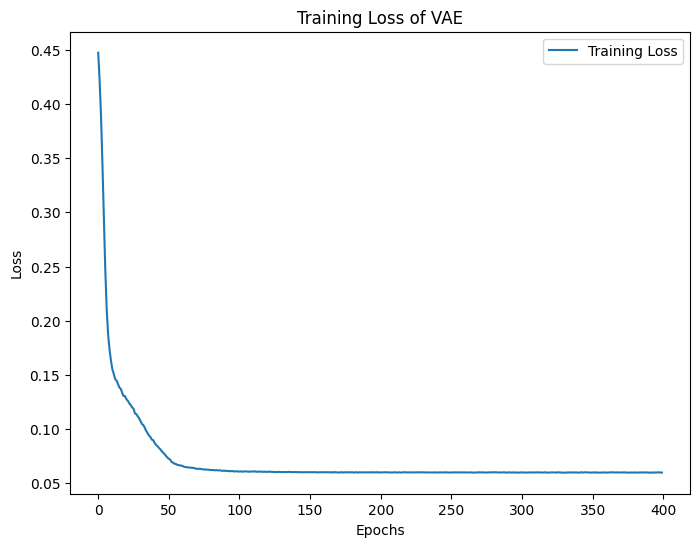

In [ ]:
# Assuming loss_values contains the stored loss values from training
plt.figure(figsize=(8, 6))
plt.plot(vae.rec_loss, label='Training Loss')
plt.title('Training Loss of VAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[0.010456691157817841, 0.010322633707523347, 0.014330933487415314, 0.02450523021221161, 0.040170143699646, 0.053287947130203246, 0.056389832639694215, 0.055461194086074826, 0.05410063910484314, 0.052062227821350095, 0.04935986099243164, 0.04719505438804626, 0.04527821989059448, 0.04362560896873474, 0.042490786933898926, 0.04018728556632996, 0.03972786540985107, 0.038163591957092284, 0.03616529579162597, 0.03542034664154053, 0.03452414293289185, 0.03331676697731018, 0.032043031311035156, 0.03105271863937378, 0.029779102778434752, 0.029334425044059753, 0.027822820258140563, 0.02663261296749115, 0.025785102581977845, 0.024354881072044372, 0.02337222580909729, 0.021735941219329834, 0.02089078073501587, 0.01958862156867981, 0.018403429675102233, 0.017752595710754396, 0.01645695085525513, 0.015476509642601013, 0.014644545459747315, 0.013589195811748505, 0.012781098067760467, 0.011542446899414062, 0.01054382688999176, 0.009581373238563538, 0.008611724281311035, 0.007693362826108933, 0.0066968

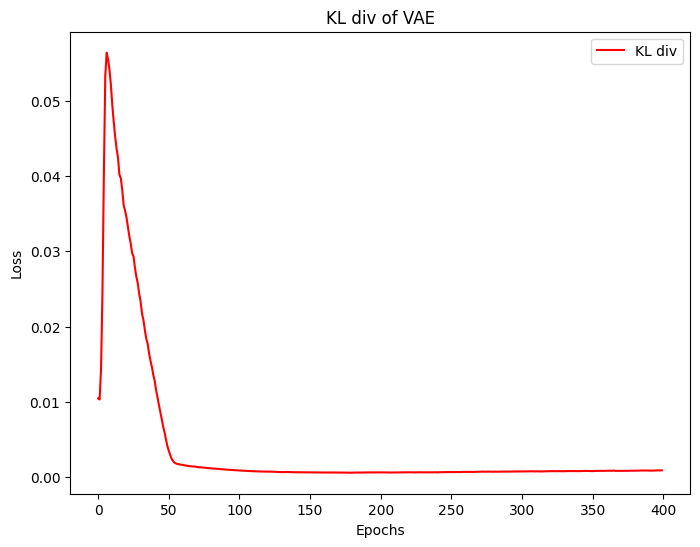

In [ ]:
print(vae.kl_div)

# Assuming loss_values contains the stored loss values from training
plt.figure(figsize=(8, 6))
plt.plot(np.array(vae.kl_div), label='KL div', c="red")
plt.title('KL div of VAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

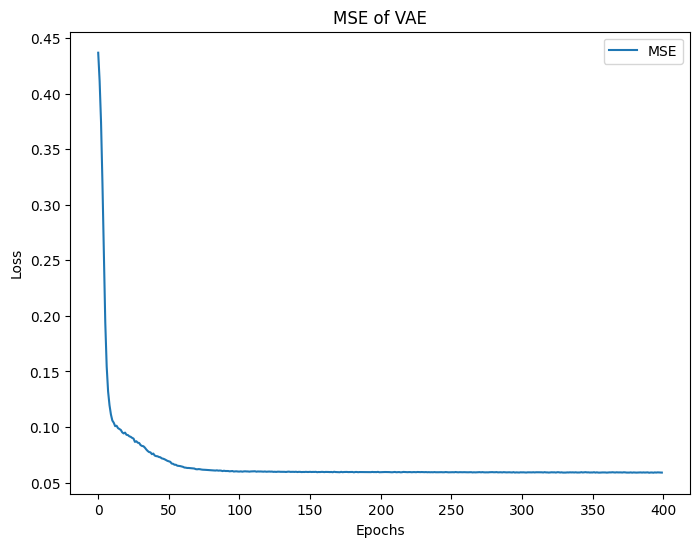

In [ ]:
# Assuming loss_values contains the stored loss values from training
plt.figure(figsize=(8, 6))
plt.plot(vae.mse, label='MSE')
plt.title('MSE of VAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()